<a href="https://colab.research.google.com/github/ddezouza/Data110/blob/main/DanielaMelo_Data110_Project1_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fatal Police Shootings
#### By: Daniela Melo

## Introduction

Police brutality is a topic that generates a lot of divisive discussions in the United States. There are countless examples of how it has been seen to affect marginalized communities and the mentally ill to a greater extent. I wanted to have a look at what data we have that can provide further insight into this topic, so I chose to use the Washington Post's Fatal Police Shootings Dataset.

We have a version of this dataset on the shared Drive folder (Professor Rachel's Dataset Collection), but I chose to use the Washington Post's github version of the same dataset, as that one is kept up to date and has more data points than the version in the shared Drive folder. The WP's downloadable file can be found at the following URL: https://github.com/washingtonpost/data-police-shootings/blob/master/v2/fatal-police-shootings-data.csv

The dataset consists of details for each police-involved killing in the United States, compiled by the Washington post from 2015 onward. Each entry includes the victim's name, age, racial background, whether they were armed/unarmed, as well as whether they ran from police and whether mental illness was a factor in the altercation. In addition, the location of each reported shooting is available as both a latitute-longitude and as entries for State, County, and City.

## Data Analysis

In [1]:
### Set up: Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install rpy2
!pip install joypy
import plotly
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objects as go

### Preliminary Review of the Dataset

In [2]:
### Importing Dataset
shootings_df=pd.read_csv('https://raw.githubusercontent.com/ddezouza/Data110/refs/heads/main/Project1/fatal-police-shootings-data%20(2).csv')

### Reviewing Dataset
shootings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10428 entries, 0 to 10427
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          10428 non-null  int64  
 1   date                        10428 non-null  object 
 2   threat_type                 10360 non-null  object 
 3   flee_status                 8931 non-null   object 
 4   armed_with                  10217 non-null  object 
 5   city                        10354 non-null  object 
 6   county                      5737 non-null   object 
 7   state                       10428 non-null  object 
 8   latitude                    9297 non-null   float64
 9   longitude                   9296 non-null   float64
 10  location_precision          9297 non-null   object 
 11  name                        10100 non-null  object 
 12  age                         10046 non-null  float64
 13  gender                      104

In [3]:
shootings_df.head(5)

,id,date,threat_type,flee_status,armed_with,city,county,state,latitude,longitude,location_precision,name,age,gender,race,race_source,was_mental_illness_related,body_camera,agency_ids
0,3,2015-01-02,point,not,gun,Shelton,Mason,WA,47.246826,-123.121592,not_available,Tim Elliot,53.0,male,A,not_available,True,False,73
1,4,2015-01-02,point,not,gun,Aloha,Washington,OR,45.487421,-122.891696,not_available,Lewis Lee Lembke,47.0,male,W,not_available,False,False,70
2,5,2015-01-03,move,not,unarmed,Wichita,Sedgwick,KS,37.694766,-97.280554,not_available,John Paul Quintero,23.0,male,H,not_available,False,False,238
3,8,2015-01-04,point,not,replica,San Francisco,San Francisco,CA,37.762910,-122.422001,not_available,Matthew Hoffman,32.0,male,W,not_available,True,False,196
4,9,2015-01-04,point,not,other,Evans,Weld,CO,40.383937,-104.692261,not_available,Michael Rodriguez,39.0,male,H,not_available,False,False,473


#### Comments:
When looking at the original dataset, it is clear that there are a significant number of missing values. Most of the data is not numerical in nature, and most of the variables associated with each shooting incident are categorical or logical in nature. I decided that the first step in my EDA would be to remove missing values and select only a subset of columns I was most interested in looking at.

### Data Wrangling: Preparing Dataset for Analysis

In [4]:
#Cleaning the Dataset
#Selecting variables of interest
shootingsclean_df=shootings_df[['date',
                                'threat_type',
                                'flee_status',
                                'armed_with',
                                'state',
                                'name',
                                'age',
                                'gender',
                                'race',
                                'was_mental_illness_related',
                                'body_camera']]
#Removing NAs
shootingsclean_df=shootingsclean_df.dropna()
#Excluding mixed-race options to simplify analysis
shootingsclean_df=shootingsclean_df[shootingsclean_df['race'].isin(['W','B','H','A'])]
#Renaming Race values to improve readability
recode_dict={'W':'White','B':'Black','A':'Asian','H':'Hispanic'}
shootingsclean_df['race']=shootingsclean_df['race'].replace(recode_dict)

In [5]:
### Reviewing Clean Dataset
shootingsclean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7550 entries, 0 to 10424
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   date                        7550 non-null   object 
 1   threat_type                 7550 non-null   object 
 2   flee_status                 7550 non-null   object 
 3   armed_with                  7550 non-null   object 
 4   state                       7550 non-null   object 
 5   name                        7550 non-null   object 
 6   age                         7550 non-null   float64
 7   gender                      7550 non-null   object 
 8   race                        7550 non-null   object 
 9   was_mental_illness_related  7550 non-null   bool   
 10  body_camera                 7550 non-null   bool   
dtypes: bool(2), float64(1), object(8)
memory usage: 604.6+ KB


#### Comments:
I now have a much easier to use dataset, with only the more interesting variables, as well as no missing values. I do have one problem though - the date variable is currently coming in as an 'object' data type. This isn't really helpful as I want to look at changes over time, so I had to change the date variable into a date-time data type. I also wanted to look at yearly comparisons, so I had to extract the year information from the date's current format.

In [6]:
#Correcting Date format
shootingsclean_df['date']=pd.to_datetime(shootingsclean_df['date'])

#Extracting Year and Month from date
shootingsclean_df['year'] = pd.DatetimeIndex(shootingsclean_df['date']).year
shootingsclean_df['month'] = pd.DatetimeIndex(shootingsclean_df['date']).month

#Getting Abbreviated Month Name
shootingsclean_df['month_name']=pd.to_datetime(shootingsclean_df['month'], format='%m').dt.month_name().str.slice(stop=3)

In [7]:
#Reviwing dataset information
shootingsclean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7550 entries, 0 to 10424
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date                        7550 non-null   datetime64[ns]
 1   threat_type                 7550 non-null   object        
 2   flee_status                 7550 non-null   object        
 3   armed_with                  7550 non-null   object        
 4   state                       7550 non-null   object        
 5   name                        7550 non-null   object        
 6   age                         7550 non-null   float64       
 7   gender                      7550 non-null   object        
 8   race                        7550 non-null   object        
 9   was_mental_illness_related  7550 non-null   bool          
 10  body_camera                 7550 non-null   bool          
 11  year                        7550 non-null   int32         
 

In [8]:
shootingsclean_df.head()

,date,threat_type,flee_status,armed_with,state,name,age,gender,race,was_mental_illness_related,body_camera,year,month,month_name
0,2015-01-02,point,not,gun,WA,Tim Elliot,53.0,male,Asian,True,False,2015,1,Jan
1,2015-01-02,point,not,gun,OR,Lewis Lee Lembke,47.0,male,White,False,False,2015,1,Jan
2,2015-01-03,move,not,unarmed,KS,John Paul Quintero,23.0,male,Hispanic,False,False,2015,1,Jan
3,2015-01-04,point,not,replica,CA,Matthew Hoffman,32.0,male,White,True,False,2015,1,Jan
4,2015-01-04,point,not,other,CO,Michael Rodriguez,39.0,male,Hispanic,False,False,2015,1,Jan


In [9]:
shootingsclean_df.describe()

,date,age,year,month
count,7550,7550.000000,7550.000000,7550.000000
mean,2019-09-04 17:05:21.377483520,36.975232,2019.194967,6.307417
min,2015-01-02 00:00:00,4.000000,2015.000000,1.000000
25%,2017-02-24 00:00:00,27.000000,2017.000000,3.000000
50%,2019-07-13 00:00:00,35.000000,2019.000000,6.000000
75%,2022-01-26 00:00:00,45.000000,2022.000000,9.000000
max,2024-12-30 00:00:00,92.000000,2024.000000,12.000000
std,NaN,12.634547,2.864193,3.456244


### First Impressions:

Using the describe function, I get a pretty decent overview of the numerical variables in my data. I can say that the mean age at which the victims were killed by police was about 37 yo, and that the youngest recorded incident victim was a four year old. I'd be interested in looking at how the age distribution of the victims might differ based on their racial backgrounds.  

### Visualization: Number of Police Shooting Fatalities per Year

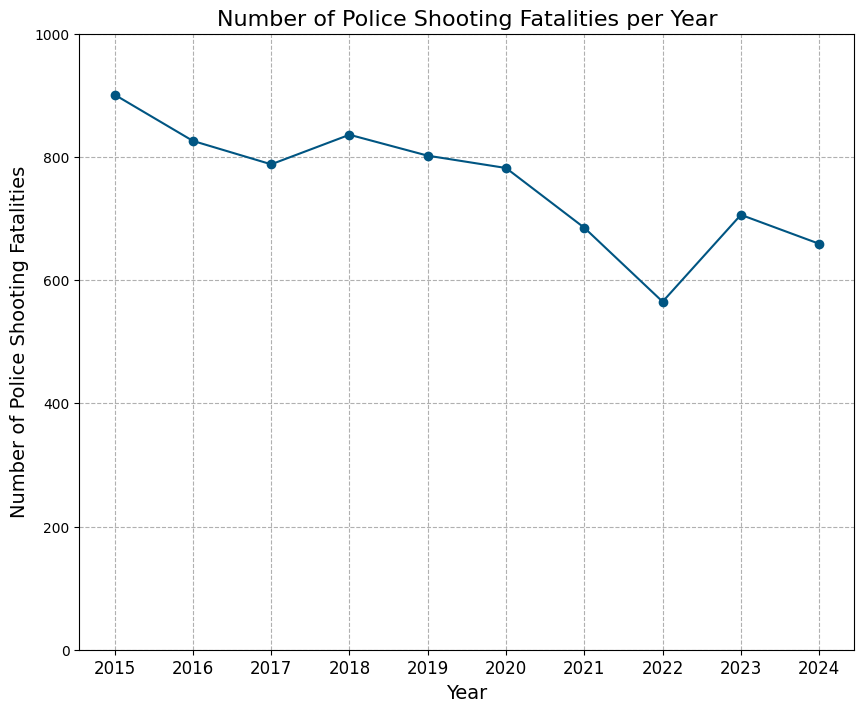

In [27]:
# Need number of shootings per year
yearly_counts = shootingsclean_df['year'].value_counts().sort_index()
#Plotting
plt.figure(figsize=(10,8))
plt.plot(yearly_counts.index, yearly_counts.values, marker='o',color='#005582')
plt.xlabel('Year',fontsize=14)
plt.ylabel('Number of Police Shooting Fatalities',fontsize=14)
plt.title('Number of Police Shooting Fatalities per Year',fontsize=16)
plt.ylim(0,1000)
plt.xticks(yearly_counts.index, fontsize=12)
plt.grid(linestyle='--',zorder=0)
plt.show()

#### Image Description:

I wanted to look at change over time, so I created a time series showcasing the number of police shooting fatalities per year for the sample. It is clear there is a trend downwards when it comes to police shooting fatalities according to this data. 2022 had the lowest number of fatalities, with 565 deaths.

#### Visualization:Number of Incidents by Race

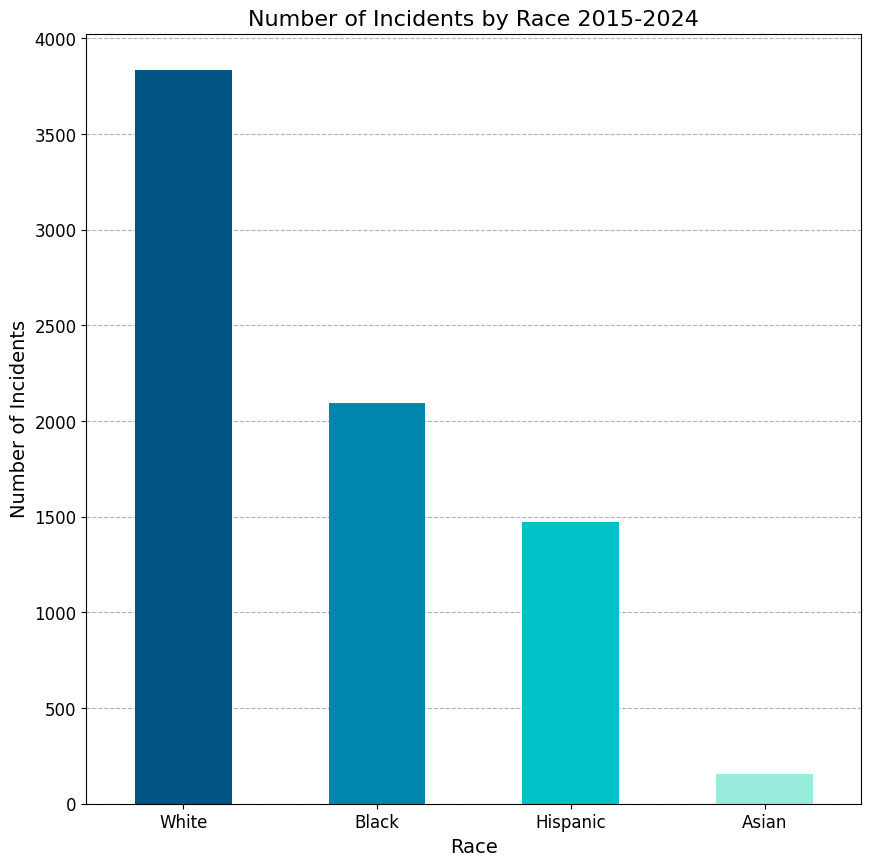

In [71]:
plt.figure(figsize=(10,10))
shootingsclean_df['race'].value_counts().plot.bar(color=['#005582','#0086ad','#00c2c7','#97ebdb'],zorder=2)
plt.xticks(rotation=0,fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Race', fontsize=14)
plt.ylabel('Number of Incidents', fontsize=14)
plt.title('Number of Incidents by Race 2015-2024',fontsize=16)
plt.grid(axis='y',linestyle='--',zorder=0)
plt.show()

#### Image Description:

A vertical bar plot showcasing the number of police shooting fatalities per racial group. Most incident victims were white, with the lowest number of victims being of Asian background. While most victims were white based solely on raw numbers, Black americans, which represent approximately 14% of the US population according to the 2023 census, represent about 28% of the fatal police shooting victims in the sample so additional context is needed to get a full understanding of the meaning of the racial distribution of the sample.

### Visualization: Incidents per Year, by Race

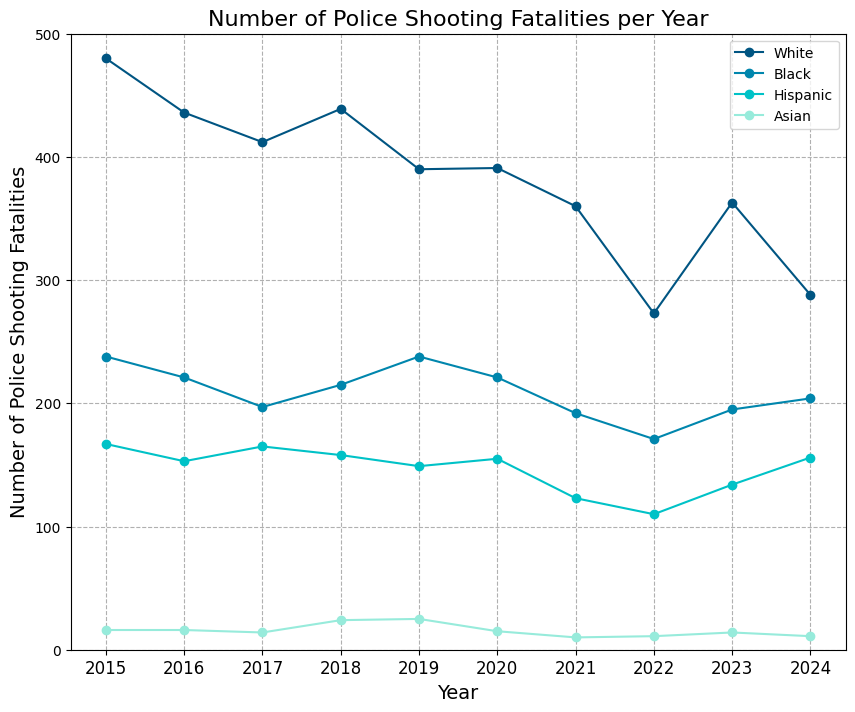

In [44]:
#Need counts per year, per race
shootings_white=shootingsclean_df[shootingsclean_df['race']=='White']
shootings_black=shootingsclean_df[shootingsclean_df['race']=='Black']
shootings_his=shootingsclean_df[shootingsclean_df['race']=='Hispanic']
shootings_asian=shootingsclean_df[shootingsclean_df['race']=='Asian']
#Getting Year Counts:
year_white = shootings_white['year'].value_counts().sort_index()
year_black=shootings_black['year'].value_counts().sort_index()
year_his=shootings_his['year'].value_counts().sort_index()
year_asian=shootings_asian['year'].value_counts().sort_index()
#Plotting
plt.figure(figsize=(10,8))
plt.plot(year_white.index, year_white.values, marker='o',color='#005582',label="White")
plt.plot(year_black.index, year_black.values, marker='o',color='#0086ad',label="Black")
plt.plot(year_his.index, year_his.values, marker='o',color='#00c2c7',label="Hispanic")
plt.plot(year_asian.index, year_asian.values, marker='o',color='#97ebdb',label="Asian")
plt.xlabel('Year',fontsize=14)
plt.ylabel('Number of Police Shooting Fatalities',fontsize=14)
plt.title('Number of Police Shooting Fatalities per Year',fontsize=16)
plt.ylim(0,500)
plt.xticks(yearly_counts.index, fontsize=12)
plt.grid(linestyle='--',zorder=0)
plt.legend()
plt.show()

#### Image Description

As mentioned, I wanted to look at changes over time, so this is time series data for the number of police shooting fatalities per year, grouped by race. While all groups show a drop in number of fatalities between 2021 and 2022, the drop for the white group is much more drastic. Concerningly, while the number of white victims drops again between 2023 and 2024, we see an increase in the number of black and hispanic victims between 2022 and 2024.

### Visualization: Age  Distribution of Fatal Police Shootings

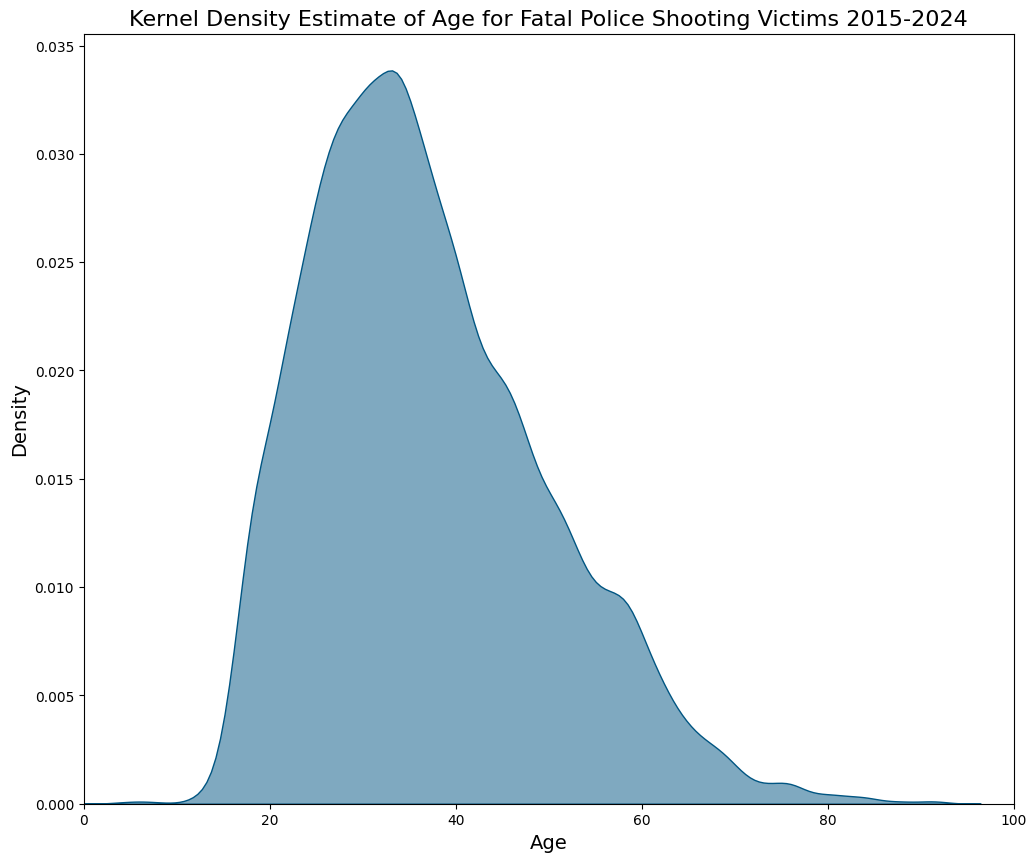

In [95]:
plt.figure(figsize=(12, 10))
sns.kdeplot(shootingsclean_df['age'], fill=True, color="#005582", alpha=0.5,bw_adjust=.70)
plt.title('Kernel Density Estimate of Age for Fatal Police Shooting Victims 2015-2024',fontsize=16)
plt.xlabel('Age',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.xlim(0, 100)
plt.show()

#### Image Description:
I wanted to visualize the age distribution - the summary gave me a good idea, but I decided to get it in a visual. This is a KDE plot for the age distribution of police shooting fatalities between 2015-2024. The dataset trends relatively young, with greatest density falling below 40 years of age.

#### Visualization: Age Distribution of Victims by Race

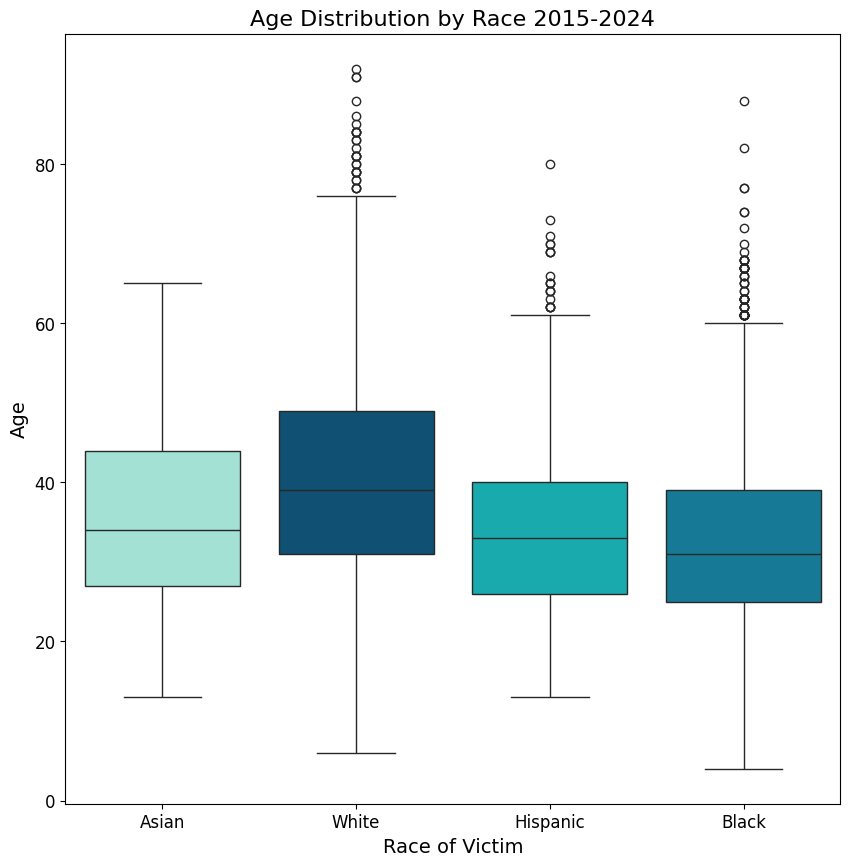

In [68]:
plt.figure(figsize=(10,10))
sns.boxplot(x='race', y='age', data=shootingsclean_df, palette=['#97ebdb','#005582','#00c2c7','#0086ad'],hue='race',legend=False)
plt.title('Age Distribution by Race 2015-2024', fontsize=16)
plt.xlabel('Race of Victim', fontsize=14)
plt.ylabel('Age', fontsize=14)
plt.tick_params(labelsize=12)
plt.show()

#### Image Description

Box plots showing the age distribution for fatal police shooting victims by race. It is clear that while White victims had a greater range of ages, Black and Hispanic victims were, on average, younger. I originally chose a ridgeline plot, but transitioned to histograms since the mean could be more easily seen for each group.

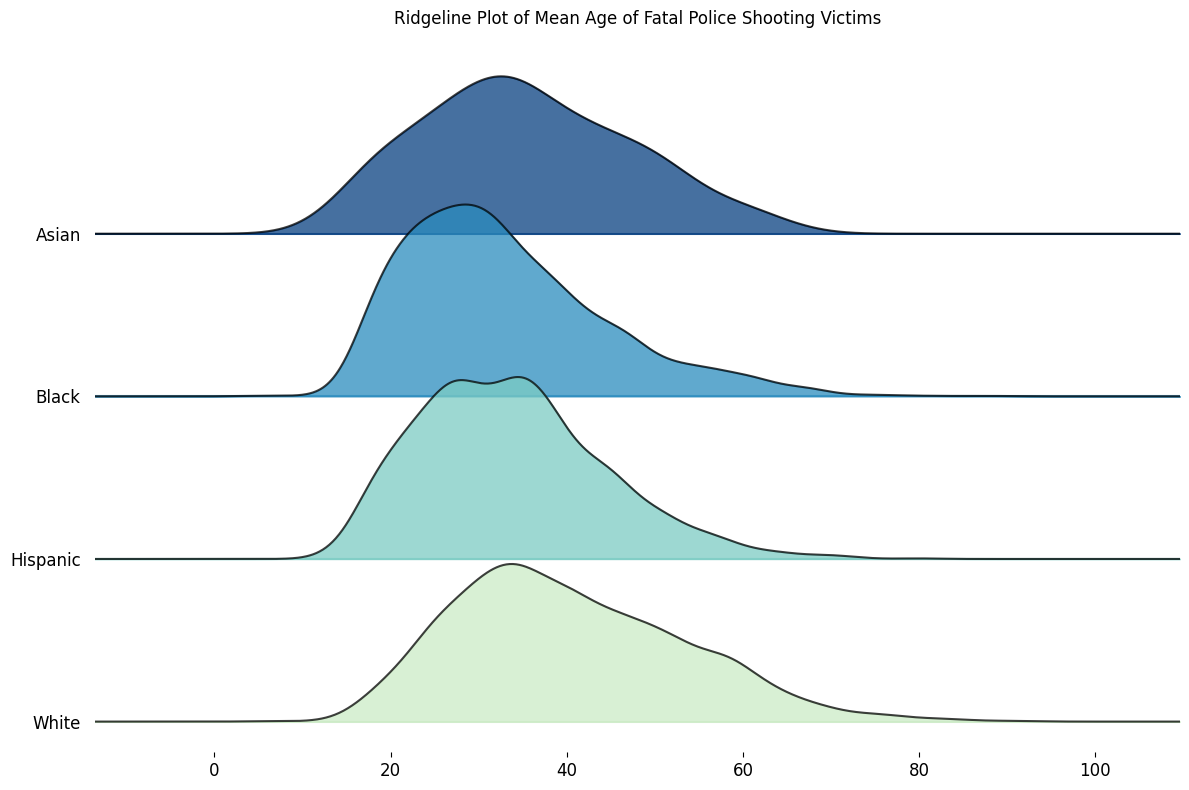

In [74]:
from joypy import joyplot
fig, axes = joyplot(shootingsclean_df,
                    by='race',
                    column='age',
                    figsize=(12, 8),
                    colormap=plt.cm.GnBu_r,
                    ylabelsize=12,
                    xlabelsize=12,
                    title="Ridgeline Plot of Mean Age of Fatal Police Shooting Victims",
                    alpha=0.75)

#### Image Description:

A Ridgeline plot also showing age distribution by race of fatal police shooting victims. The ridgeline plot shows the spread for ages pretty well, but I feel like the differences in the mean are slightly less clear.

### Visualization: Fatal Police Shootings per State

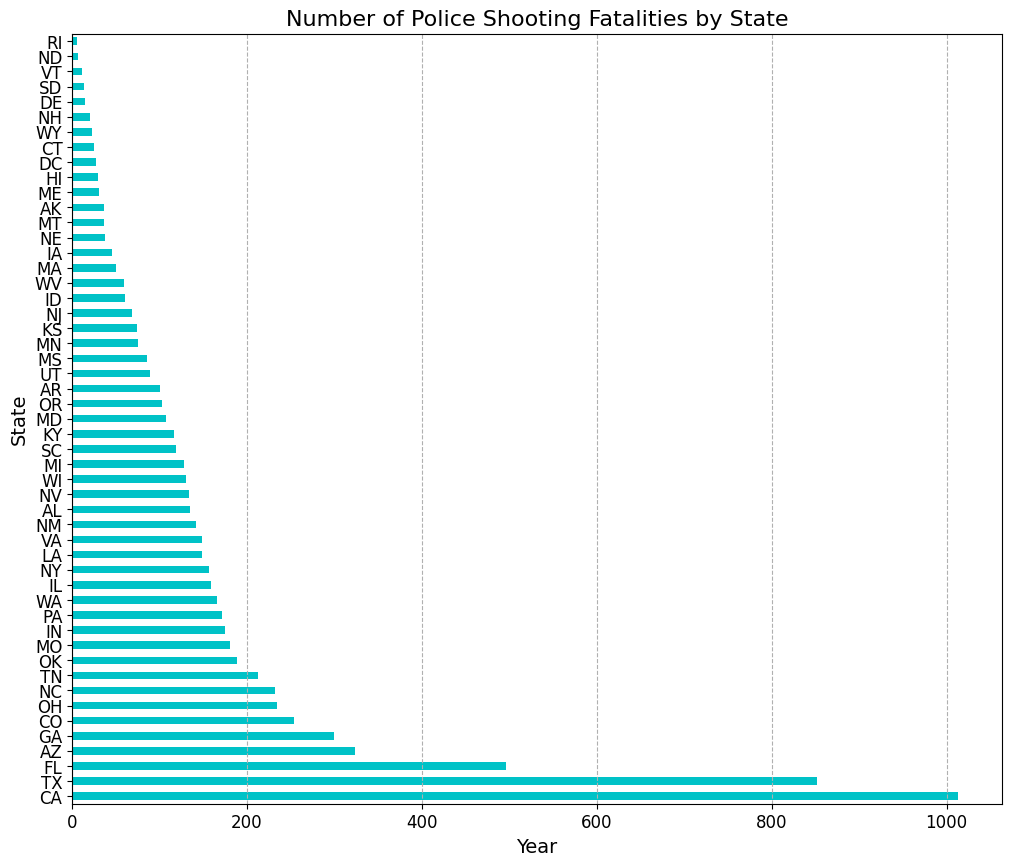

In [69]:
plt.figure(figsize=(12,10))
shootingsclean_df['state'].value_counts().plot.barh(color='#00c2c7')
plt.xlabel('Year',fontsize=14)
plt.ylabel('State',fontsize=14)
plt.title('Number of Police Shooting Fatalities by State',fontsize=16)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.grid(axis='x',linestyle='--',zorder=0)
plt.show()

#### Image Description:
I wanted to have a look at what states have the highest police shooting fatalities. I created a horizontal bar plot with the number of police shootings by state. While the data can be read, I don't think it's a very good visualization for this. There's too many states, and the graph feels crowded, so I looked for an alternate way to display the data.

In [100]:
perstate = shootingsclean_df['state'].value_counts().to_dict()
data = [dict(type = 'choropleth',colorscale = 'teal',locations = list(perstate.keys()),locationmode = 'USA-states',z = list(perstate.values()))]
layout = dict(title = 'Police Shooting Fatalities per State 2015-2024',geo = dict(scope = 'usa', showlakes = True,lakecolor = 'white'))
figure = dict(data = data, layout = layout)
iplot(figure)
plt.show()

#### Image Description:
This is a US heat map showcasing the number of police shooting fatalities per state. California and Texas had the highest number of shooting fatalities, with Florida following.

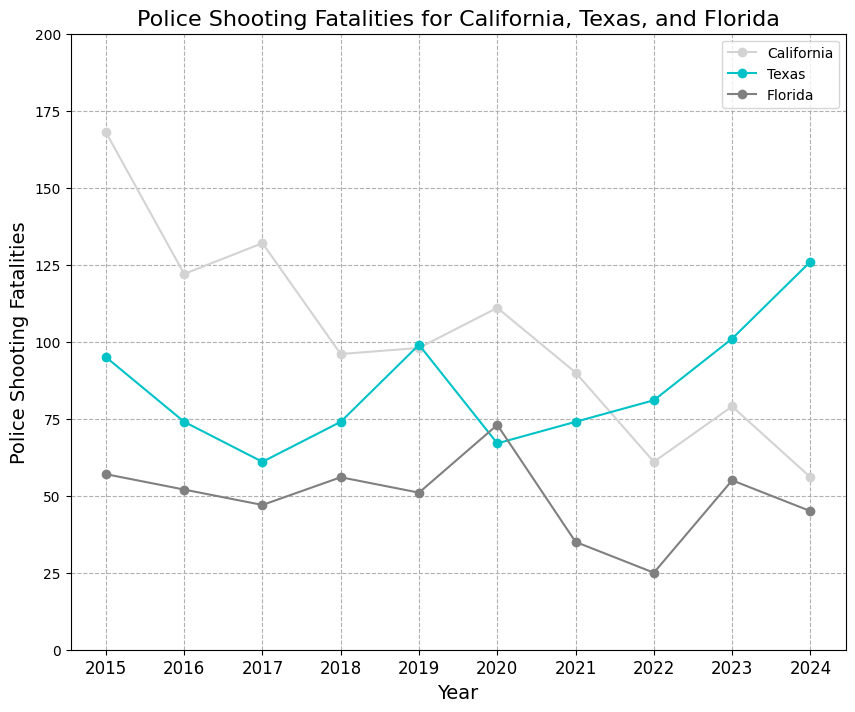

In [99]:
shootings_CA=shootingsclean_df[shootingsclean_df['state']=='CA']
shootings_TX=shootingsclean_df[shootingsclean_df['state']=='TX']
shootings_FL=shootingsclean_df[shootingsclean_df['state']=='FL']

#Getting Year Counts:
year_CA = shootings_CA['year'].value_counts().sort_index()
year_TX=shootings_TX['year'].value_counts().sort_index()
year_FL=shootings_FL['year'].value_counts().sort_index()

#Plotting
plt.figure(figsize=(10,8))
plt.plot(year_CA.index, year_CA.values, marker='o',color='lightgray',label="California")
plt.plot(year_TX.index, year_TX.values, marker='o',color='#00c2c7',label="Texas")
plt.plot(year_FL.index, year_FL.values, marker='o',color='gray',label="Florida")
plt.xlabel('Year',fontsize=14)
plt.ylabel('Police Shooting Fatalities',fontsize=14)
plt.title('Police Shooting Fatalities for California, Texas, and Florida',fontsize=16)
plt.ylim(0,200)
plt.xticks(yearly_counts.index, fontsize=12)
plt.grid(linestyle='--',zorder=0)
plt.legend()
plt.show()

### Image Description

I decided to look at the states with the most police shooting fatalities and how they have been changing over time. I chose to highlight Texas in the graph by making it the only one in blue, because while California and Florida follow the general downward trend in number of police shooting fatalities, Texas is actually seeing an increase in that number, showing consistently higher numbers of fatal police shootings between 2020 and 2024.

### Visualization: Mental-illness Related Shootings

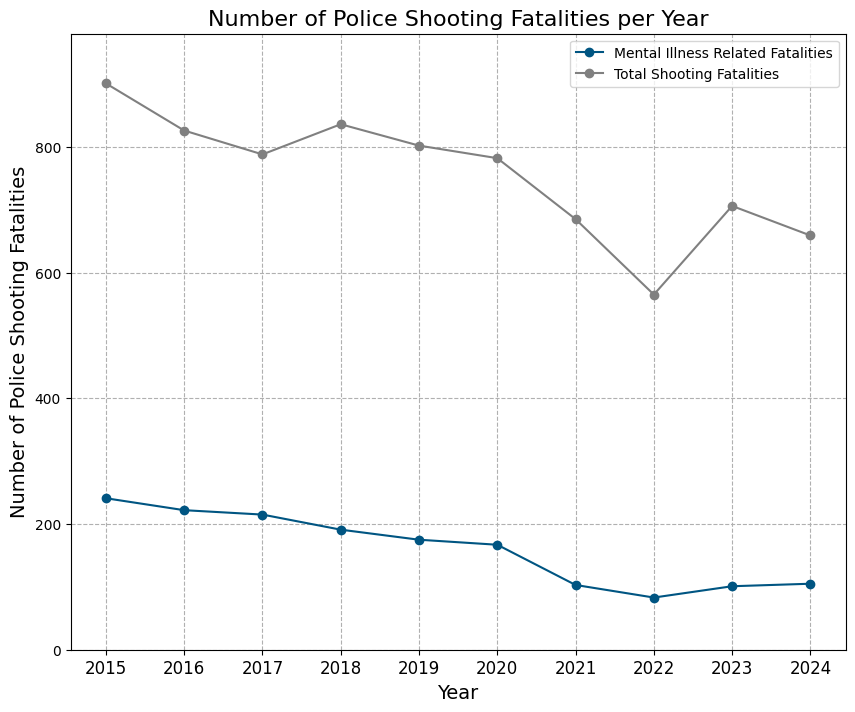

In [86]:
#Mental Illness Related Shootings
shootings_mi=shootingsclean_df[shootingsclean_df['was_mental_illness_related']==True]
#Getting Year Counts:
year_mi = shootings_mi['year'].value_counts().sort_index()

#Plotting
plt.figure(figsize=(10,8))
plt.plot(year_mi.index, year_mi.values, marker='o',color='#005582',label="Mental Illness Related Fatalities")
plt.plot(yearly_counts.index, yearly_counts.values, marker='o',color='grey',label='Total Shooting Fatalities')

plt.xlabel('Year',fontsize=14)
plt.ylabel('Number of Police Shooting Fatalities',fontsize=14)
plt.title('Number of Police Shooting Fatalities per Year',fontsize=16)
plt.ylim(0,980)
plt.xticks(yearly_counts.index, fontsize=12)
plt.grid(linestyle='--',zorder=0)
plt.legend()
plt.show()

#### Image Description:

Time series graph comparing total number of police shooting fatalities to the number of police shooting fatalities where mental illness was a factor. We see a lot more fluctuation in the number of total police shootins, while the number of mental illness related incidents decreases quite consistently until 2020. There is a slight increase in the number of mental ilness related police fatalities between 2022 and 2024, but they are still much lower in incidence than in 2015.

### Visualization: Mental Illness Related Shootings by Race

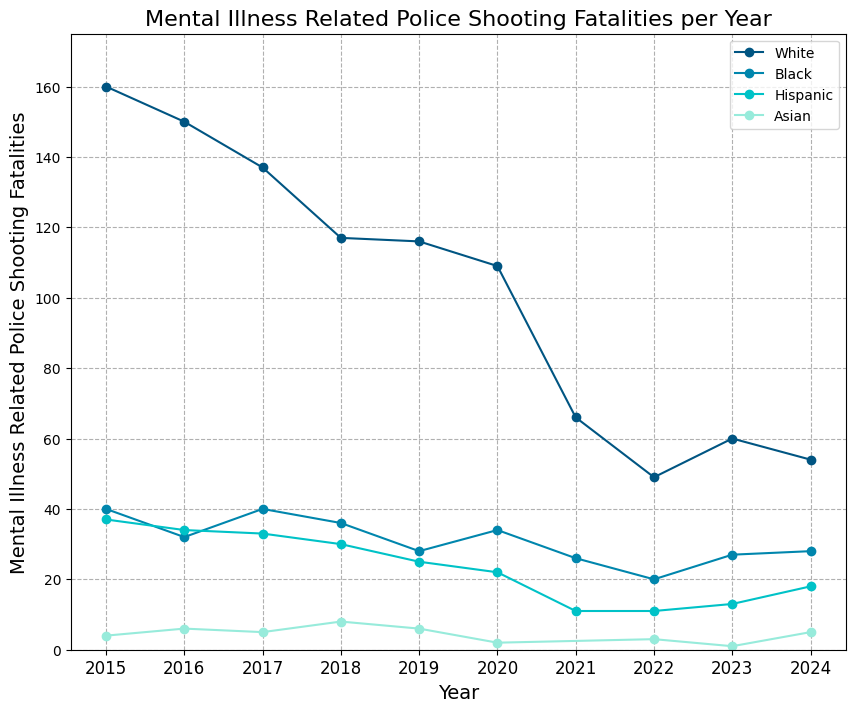

In [89]:
#Need counts per year, per race
white_mi=shootings_mi[shootings_mi['race']=='White']
black_mi=shootings_mi[shootings_mi['race']=='Black']
his_mi=shootings_mi[shootings_mi['race']=='Hispanic']
asian_mi=shootings_mi[shootings_mi['race']=='Asian']
#Getting Year Counts:
year_white_mi = white_mi['year'].value_counts().sort_index()
year_black_mi=black_mi['year'].value_counts().sort_index()
year_his_mi=his_mi['year'].value_counts().sort_index()
year_asian_mi=asian_mi['year'].value_counts().sort_index()
#Plotting
plt.figure(figsize=(10,8))
plt.plot(year_white_mi.index, year_white_mi.values, marker='o',color='#005582',label="White")
plt.plot(year_black_mi.index, year_black_mi.values, marker='o',color='#0086ad',label="Black")
plt.plot(year_his_mi.index, year_his_mi.values, marker='o',color='#00c2c7',label="Hispanic")
plt.plot(year_asian_mi.index, year_asian_mi.values, marker='o',color='#97ebdb',label="Asian")
plt.xlabel('Year',fontsize=14)
plt.ylabel('Mental Illness Related Police Shooting Fatalities',fontsize=14)
plt.title('Mental Illness Related Police Shooting Fatalities per Year',fontsize=16)
plt.ylim(0,175)
plt.xticks(yearly_counts.index, fontsize=12)
plt.grid(linestyle='--',zorder=0)
plt.legend()
plt.show()

### Image Description:
Time series graph showing the number of mental illness related police shooting fatalities by race. There was a sharp decrease in the number of white mentally-ill victims of police shootings between 2020 and 2022. This was also the only group to see a decrease between 2023 and 2024.

## Conclusion:
This dataset is very extensive and of course can yield a lot more information than what I focused on.

I did get some interesting insights, most significantly in that the number of police shooting fatalities overall is on a downward trend for the most part, though there was an increase overall between 2022 and 2023.

Unfortunately, the data also shows there was an increase in the number of Black and Hispanic police shooting victims between 2022 and 2024, which, should it continue, could be concerning.

Interestingly, the majority of states have had less than 300 police shooting fatalities between 2015 and 2024 which I found unexpected. However, states like California and Texas have had a significant number of fatalities. Most concerningly, Texas shows an increase in the number of fatal police shootings over time, with the number steadily increasing between 2020 and 2024.

When looking at mental illness related shootings, they make up a small portion of total fatal police shootings per year, but are still represented significantly. We do see a general downward trend, with mental illness related fatal shootings decreasing year over year. We do however see a slight increase between 2021 and 2024 for fatal police shootings of mentally-ill black and hispanic americans.

#### Future Analysis

I'd be really interested in seeing how the trends I identified come to bear in the next few years. In addition, I'd like to see whether any particular group was more likely to be shot when they were unarmed, and if shootings of unarmed individuals were more likely if they were mentally ill.